This notebook is responsible for the training of the prediction of the SCP
codes model.

In [1]:
import pandas as pd
import numpy as np
import pickle
import wfdb
import os
from ast import literal_eval
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from sklearn.utils import shuffle
from sklearn import metrics

In [2]:
# Random magic number for classifiers and shuffling data
SHUFFLE_NUM = 35137

# Whether to ditch values with confidence below a certain point
DITCH_LOW_CONF = 100

# Whether to save the models to the drive
SAVE_MODEL = False

# List of the 12 waveforms names
WAVEFORMS = ["I", "II", "III", "AVR", "AVL", "AVF", "V1", "V2", "V3", "V4", "V5", "V6"]

This dataset already includes a "strat_fold" column, already created by the
authors so the training data is already chosen by the authors and not randomly
and produce unwanted biases

In [3]:
# Dataset directory
# ptb_dir = "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"
ptb_dir = "ptb/" # In Compute Engine server

# Whether to use the high or low resolution dataset
lowres = True
filetype = "filename_" + ("lr" if lowres else "hr")

# Loads the dataset with only the scp codes, strat fold and the filename
df = pd.read_csv(ptb_dir+"ptbxl_database.csv", index_col=["ecg_id"], usecols=["ecg_id", "scp_codes", "strat_fold", filetype])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21837 entries, 1 to 21837
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   scp_codes    21837 non-null  object
 1   strat_fold   21837 non-null  int64 
 2   filename_lr  21837 non-null  object
dtypes: int64(1), object(2)
memory usage: 682.4+ KB


In [4]:
df.head()

,scp_codes,strat_fold,filename_lr
ecg_id,,,
1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",3,records100/00000/00001_lr
2,"{'NORM': 80.0, 'SBRAD': 0.0}",2,records100/00000/00002_lr
3,"{'NORM': 100.0, 'SR': 0.0}",5,records100/00000/00003_lr
4,"{'NORM': 100.0, 'SR': 0.0}",3,records100/00000/00004_lr
5,"{'NORM': 100.0, 'SR': 0.0}",4,records100/00000/00005_lr


# Here we process the scp_codes into multilabel array

In [5]:
# Reads the scp csv file with the category as index
scp_df = pd.read_csv(ptb_dir+'scp_statements.csv', index_col=0)
scp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71 entries, NDT to TRIGU
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   description                    71 non-null     object 
 1   diagnostic                     44 non-null     float64
 2   form                           19 non-null     float64
 3   rhythm                         12 non-null     float64
 4   diagnostic_class               44 non-null     object 
 5   diagnostic_subclass            44 non-null     object 
 6   Statement Category             71 non-null     object 
 7   SCP-ECG Statement Description  71 non-null     object 
 8   AHA code                       37 non-null     float64
 9   aECG REFID                     23 non-null     object 
 10  CDISC Code                     13 non-null     object 
 11  DICOM Code                     13 non-null     object 
dtypes: float64(4), object(8)
memory usage: 7.2+ KB


In [6]:
# Convert json string as python object
scp_codes = df["scp_codes"].apply(lambda x : literal_eval(x))

def all_class():
  # ! Unused
  scp_length = len(scp_df)
  
  def create_multilabel(scpc: dict):
    # Create empty list with the length of scp
    res = [ 0 for _ in range(scp_length) ]
    
    for x, y in scpc.items():
      res[scp_df.index.get_loc(x)] = 1
      
    return res
  
  # For every scp_codes in df, we will create a new mutlilabel 2d array
  # New column
  df["result"] = scp_codes.apply(create_multilabel)
  
  return scp_length

def super_class():
  super_list = list(set(scp_df["diagnostic_class"]))
  super_list.remove(np.nan)
  # Sort so we don't have randomly sorted labels from set()
  super_list = sorted(super_list)
  scp_length = len(super_list)
  
  def create_superclass(scpc: dict):
    # Create empty list with the length of scp
    res = [ 0 for _ in range(scp_length) ]
    
    # Sort the items based on confidence
    for x, y in sorted(scpc.items(), key=lambda x : x[1], reverse=True):
      try:
        res[super_list.index(scp_df.loc[x]["diagnostic_class"])] = 1
      except ValueError:
        pass
    return res
  
  # For every scp_codes in df, we will create a new mutlilabel 2d array
  # New column
  df["result"] = scp_codes.apply(create_superclass)
  
  print(f"Your labels are: {super_list}")
  
  return super_list, scp_length

# How many scp categories are there, and filters the data
super_list, scp_length = super_class()

df.head()

Your labels are: ['CD', 'HYP', 'MI', 'NORM', 'STTC']


,scp_codes,strat_fold,filename_lr,result
ecg_id,,,,
1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",3,records100/00000/00001_lr,"[0, 0, 0, 1, 0]"
2,"{'NORM': 80.0, 'SBRAD': 0.0}",2,records100/00000/00002_lr,"[0, 0, 0, 1, 0]"
3,"{'NORM': 100.0, 'SR': 0.0}",5,records100/00000/00003_lr,"[0, 0, 0, 1, 0]"
4,"{'NORM': 100.0, 'SR': 0.0}",3,records100/00000/00004_lr,"[0, 0, 0, 1, 0]"
5,"{'NORM': 100.0, 'SR': 0.0}",4,records100/00000/00005_lr,"[0, 0, 0, 1, 0]"


In [7]:
def apply_superdiagnostic(scpc: dict):
  for x, y in sorted(scpc.items(), key=lambda x : x[1], reverse=True):
    if scp_df.loc[x].diagnostic == 1.0:
      # Some funky codes. If we don't ditch the low confidence, just return true.
      # Else, check if y is higher than DITCH_LOW_CONF
      if DITCH_LOW_CONF == False or y >= DITCH_LOW_CONF:
        return True
  return False

super_bool = scp_codes.apply(apply_superdiagnostic)
np.unique(super_bool, return_counts=True)

(array([False,  True]), array([ 4578, 17259]))

In [8]:
from sklearn.preprocessing import StandardScaler

def get_standardizer(X):
  """Creates a standardizer
  Args:
      X (data): Must be raw
  Returns:
      StandardScaler: Scaler for dataset
  """
  if os.path.exists("datasetcache/standardizer.pkl"):
    return pickle.load(open("datasetcache/standardizer.pkl", "rb"))
  else:
    # Fit data to standardizer
    X_scaler = StandardScaler()
    X_scaler.fit(np.vstack(X).flatten()[:,np.newaxis].astype(float))
    
    # Save file
    pickle.dump(X_scaler, open("datasetcache/standardizer.pkl", "wb"), 4)
    
    return X_scaler

def apply_standardizer(X, ss):
    X_tmp = []
    for x in tqdm(X, "Applying PTB Standardizer"):
        x_shape = x.shape
        X_tmp.append(ss.transform(x.flatten()[:,np.newaxis]).reshape(x_shape))
    X_tmp = np.array(X_tmp)
    return X_tmp

def load_waveforms():
  """Loads the low or high resolution waveform data according to the `lowres`
  variable. The function iterates through the dataset and reads every file with
  rdsamp. Rdsamp returns a tuple (signal, meta), therefore to get the signal,
  [0] is needed after the function

  Returns:
      array: array of array with a dimension of `12x10*frequency` (100Hz / 500Hz
      depending on `lowres` variable)
  """
  data = None
  if os.path.exists("datasetcache/raw100.npy"):
    print("Loading saved raw dataset")
    data = np.load("datasetcache/raw100.npy", allow_pickle=True)
  else:
    # Load raw data
    # data = np.array([ wfdb.rdsamp(ptb_dir+f)[0] for f in tqdm(df[filetype], "Loading Waveform") ])
    data = np.array([ np.array([ pd.Series(wave) for wave in wfdb.rdsamp(ptb_dir+f)[0] ]) for f in tqdm(df[filetype], "Loading Waveform") ])
    pickle.dump(data, open("datasetcache/raw100.npy", "wb"), 4)

  # Scale data
  # X_scaler = get_standardizer(data)
  # data = apply_standardizer(data, X_scaler)
  
  # Transform data
  # Transpose
  data = np.transpose(data, (0, 2, 1)) # ! Transpose experiment
  
  print(f"Data Shape: {data.shape}")

  return data

# Loads all the waveform data
X = load_waveforms()

Loading saved raw dataset
Data Shape: (21837, 12, 1000)


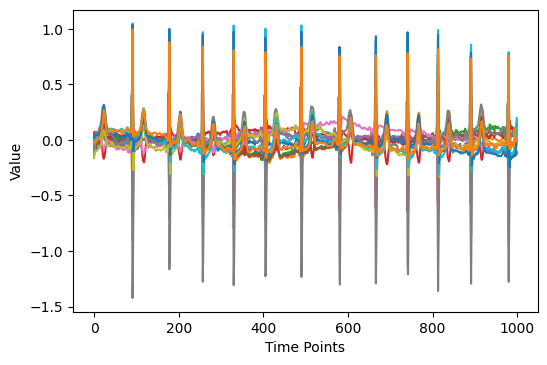

In [9]:
plt.rcParams['figure.dpi'] = 100 
for pt in X[13]:
  plt.plot(pt)
plt.xlabel("Time Points")
plt.ylabel("Value")
plt.show()

In [10]:
# Gets the Y of the dataset
Y = df
print(len(X), len(Y))

21837 21837


In [11]:
# Selects only super diagnostics
X, Y = X[super_bool], Y[super_bool]
print(f"Superbool dropped {len(df) - len(X)} data because either it does not \
have a diagnostic code, or the confidence level is below {DITCH_LOW_CONF}. \
Current data count: {len(X)}")

Superbool dropped 4578 data because either it does not have a diagnostic code, or the confidence level is below 100. Current data count: 17259


In [12]:
# Splits the dataset into training and testing based on the strat_fold
# the dataset has graciously provided us
def select_data_strat_fold(test_fold, shuffle_num=None):
  """Selects data for training and testing

  Args:
      test_fold (int): Test fold index (1-10)
      shuffle (int, optional): Seed for shuffling data. Defaults to None.

  Returns:
      (X_tr, Y_tr, X_te, Y_te): Training data, testing data.
  """
  # Select which fold we want to use
  train_sel = Y["strat_fold"] != test_fold
  test_sel = Y["strat_fold"] == test_fold
  
  # Splits the data
  # !!!!!!!!! It is very, very important to use np.where for numpy arrays.
  # !!!!!!!!! Lost almost 2 weeks because of this
  X_tr = X[np.where(train_sel)]
  Y_tr = np.array(Y[train_sel].result.to_list()).astype("float32")

  X_te = X[np.where(test_sel)]
  Y_te = np.array(Y[test_sel].result.to_list()).astype("float32")
  
  print(f"Data length before: {len(X)} {len(Y)}. Data is split with test_fold: {test_fold}\
with shape:", end=" ")
  
  print(X_tr.shape, Y_tr.shape, X_te.shape, Y_te.shape)
  
  # Scale data
  X_scaler = get_standardizer(X_tr)
  X_tr = apply_standardizer(X_tr, X_scaler)
  X_te = apply_standardizer(X_te, X_scaler)
  
  if shuffle_num != None:
    X_tr, Y_tr = shuffle(X_tr, Y_tr, random_state=shuffle_num)
    
  return X_tr, Y_tr, X_te, Y_te

## From this point, we can do the model training

In [13]:
# Load the model with tensorflow
import tensorflow as tf
# import MiniRocket.minirocket_multivariate as MiniRocket
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

2022-01-05 16:14:44.326941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-05 16:14:44.326975: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [14]:
def efficient_net(length):
  from efficientnet_lite import EfficientNetLiteB0
  base = EfficientNetLiteB0(
    input_shape=(100, 120, 1),
    weights = None,
    include_top=False,
    pooling="avg",
  )
  
  base.trainable=True
  
  model = tf.keras.Sequential([
    base,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(length, activation="softmax") # We want a classification
  ])
  
  model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
  )
  
  return model

def fit_efficient(X_tr, Y_tr, X_te, Y_te, epochs, batch_size):
  """Efficient Net model fitting
  """
  model = efficient_net(scp_length)
  
  # Reshape the data so it can be inputted
  X_tr_r = X_tr.reshape((len(X_tr), 100, 120))
  X_te_r = X_te.reshape((len(X_te), 100, 120))
  
  model.fit(
    X_tr_r,
    Y_tr,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_te_r, Y_te),
  )
  
  return model, X_te_r

def fit_inception(X_tr, Y_tr, epochs, batch_size, val_data=None):
  from Inception.inception import Classifier_INCEPTION as Inception
  from tensorflow.keras.callbacks import EarlyStopping, Callback
  
  in_model = Inception(
    "./inceptionres",
    X_tr.shape[1:],
    scp_length,
  )
  model = in_model.model
  
  metrics = {}
  class MetricCollector(Callback):
    def on_epoch_end(self, epoch, logs={}):
        for key, val in logs.items():
          if key not in metrics:
            metrics[key] = [val]
          else:
            metrics[key].append(val)
  
  model.fit(
    X_tr,
    Y_tr,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_data,
    callbacks=[
      MetricCollector(),
      in_model.callbacks[0], # Get only reduce learning rate
    #   EarlyStopping( # Stop if the val loss is not that big
    #     monitor= "val_loss",
    #     min_delta = 0.1,
    #     patience = 3,
    #   )
    ],
  )
  
  return model, metrics

def fit_rcc(X_tr, Y_tr):
  from sklearn.linear_model import SGDClassifier
  from sklearn.linear_model import RidgeClassifierCV
  from sktime.transformations.panel.rocket import MiniRocketMultivariate
  
  # IMPORTANT! In sklearn version 1.0.1, there is a bug in RidgeClassifierCV
  # that makes it unable to process multilabel targets, even though such
  # operations are said to be supported in the docs. To fix this, one must use
  # The nightly build of sklearn.
  classifier = make_pipeline(
    MiniRocketMultivariate(n_jobs=-1),
    RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
  )
  
  classifier.fit(X_tr, Y_tr)
  return classifier

def fit_forest(X_tr, Y_tr, mode="concat"):
  from sktime.classification.interval_based import TimeSeriesForestClassifier
  from sktime.transformations.panel.compose import ColumnConcatenator
  from sktime.classification.compose import ColumnEnsembleClassifier
  from sklearn.multioutput import MultiOutputClassifier
  
  # Combines multivariate data into one long one
  if mode=="concat":
    classifier = Pipeline([
      ("concatenate", ColumnConcatenator()),
      ("classify", TimeSeriesForestClassifier(
        n_estimators=100,
        min_interval=7,
        n_jobs=-1,
        random_state=1314
      )
      )
    ])
  if mode=="ensemble":
    classifier = MultiOutputClassifier(
      ColumnEnsembleClassifier(
        [("classify", TimeSeriesForestClassifier(
          n_estimators=100,
          min_interval=7,
          n_jobs=-1,
          random_state=1314
        ),
        [0]
        )],
      )
    )
  
  classifier.fit(X_tr, Y_tr)
  return classifier

def fit_sgd(X_tr, Y_tr):
  from sktime.transformations.panel.rocket import MiniRocketMultivariate
  from sklearn.multioutput import MultiOutputClassifier
  from sklearn.linear_model import SGDClassifier
  
  classifier = MultiOutputClassifier(
    make_pipeline(
      MiniRocketMultivariate(
        n_jobs=-1,
      ),
      SGDClassifier(
        loss="hinge",
        alpha=0.0003,
        learning_rate="adaptive",
        eta0=0.009,
        epsilon=0.1,
        max_iter=4000,
        random_state=1314,
        penalty="elasticnet",
        n_jobs=-1,
        verbose=0
      )
    )
  )
  
  classifier.fit(X_tr, Y_tr)
  return classifier

def fit_rfc(X_tr, Y_tr):
  from sktime.transformations.panel.rocket import MiniRocketMultivariate
  from sklearn.ensemble import RandomForestClassifier
  
  classifier = make_pipeline(
      MiniRocketMultivariate(
        n_jobs=-1,
      ),
      RandomForestClassifier(
        n_estimators=100,
        random_state=1314,
        n_jobs=-1,
      )
    )
  classifier = classifier.fit(X_tr, Y_tr)
  return classifier

In [15]:
X_tr, Y_tr, X_te, Y_te = select_data_strat_fold(10, SHUFFLE_NUM)

Data length before: 17259 17259. Data is split with test_fold: 10with shape: (15543, 12, 1000) (15543, 5) (1716, 12, 1000) (1716, 5)


Applying PTB Standardizer: 100%|█████████████████████████████████████████████████| 1716/1716 [00:00<00:00, 13511.88it/s]


In [16]:
# Extra metrics functions
from sklearn.metrics import hamming_loss, accuracy_score, classification_report, zero_one_loss

def hamming_score(y_true, y_pred):
  temp = 0
  for i in range(y_true.shape[0]):
    temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
  return temp / y_true.shape[0]

def get_metrics_str(y_true, y_pred):
  return f"""
Hamming Score: {hamming_score(y_true, y_pred)}
Hamming Loss: {hamming_loss(y_true, y_pred)}
Zero-One Loss: {zero_one_loss(y_true, y_pred)}
Accuracy Score: {accuracy_score(y_true, y_pred)}

{classification_report(y_true, y_pred, target_names=super_list, zero_division=0)}
"""

### -------------------------------------------------------------

### For training and for validating, the code should be ran up until this point. Running all training is ill-advised as it takes a lot of time and it takes a lot of RAM

### -------------------------------------------------------------

In [33]:
model_inc, metrics_inc = fit_inception(
  np.transpose(X_tr, (0, 2, 1)),
  Y_tr,
  14,
  256,
  (np.transpose(X_te, (0, 2, 1)), Y_te)
)

Epoch 1/14
61/61 [==============================] - 330s 5s/step - loss: 0.3378 - accuracy: 0.6504 - val_loss: 0.8605 - val_accuracy: 0.2541 - lr: 0.0010
Epoch 2/14
61/61 [==============================] - 326s 5s/step - loss: 0.2679 - accuracy: 0.7170 - val_loss: 0.3666 - val_accuracy: 0.6801 - lr: 0.0010
Epoch 3/14
61/61 [==============================] - 326s 5s/step - loss: 0.2491 - accuracy: 0.7269 - val_loss: 0.3607 - val_accuracy: 0.7185 - lr: 0.0010
Epoch 4/14
61/61 [==============================] - 326s 5s/step - loss: 0.2386 - accuracy: 0.7412 - val_loss: 0.3932 - val_accuracy: 0.6305 - lr: 0.0010
Epoch 5/14
61/61 [==============================] - 326s 5s/step - loss: 0.2339 - accuracy: 0.7448 - val_loss: 0.3651 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 6/14
61/61 [==============================] - 326s 5s/step - loss: 0.2280 - accuracy: 0.7499 - val_loss: 0.2929 - val_accuracy: 0.7226 - lr: 0.0010
Epoch 7/14
61/61 [==============================] - 326s 5s/step - loss: 0.2

In [38]:
model_inc.save("datasetcache/_best_inception.h5")

/home/nakamarujc/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [36]:
inc_pred = model_inc.predict(np.transpose(X_te, (0, 2, 1)))

In [37]:
print(get_metrics_str(Y_te, inc_pred.round()))


Hamming Score: 0.7539821289821286
Hamming Loss: 0.10897435897435898
Zero-One Loss: 0.3706293706293706
Accuracy Score: 0.6293706293706294

              precision    recall  f1-score   support

          CD       0.78      0.76      0.77       487
         HYP       0.73      0.45      0.56       204
          MI       0.80      0.69      0.74       398
        NORM       0.87      0.94      0.90       753
        STTC       0.84      0.66      0.74       488

   micro avg       0.83      0.76      0.79      2330
   macro avg       0.80      0.70      0.74      2330
weighted avg       0.82      0.76      0.78      2330
 samples avg       0.83      0.80      0.79      2330




Text(0.5, 0.98, 'InceptionTime training metrics')

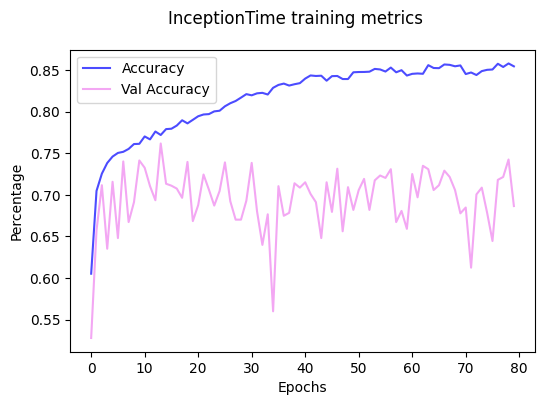

In [32]:
plt.plot(metrics_inc["accuracy"], c="blue", label="Accuracy", alpha=0.7)
plt.plot(metrics_inc["val_accuracy"], c="violet", label="Val Accuracy", alpha=0.7)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.suptitle("InceptionTime training metrics")

### EFFICIENTNETLITEV4 (Bonus!)

In [17]:
model_en = fit_efficient(X_tr, Y_tr, X_te, Y_te, 40, 1000)

2022-01-04 08:24:39.559713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-04 08:24:39.559739: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-04 08:24:39.559752: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ultra-colab-engine): /proc/driver/nvidia/version does not exist
2022-01-04 08:24:39.560064: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/40
16/16 [==============================] - 151s 9s/step - loss: 0.5969 - accuracy: 0.3616 - val_loss: 0.7726 - val_accuracy: 0.2995
Epoch 2/40
16/16 [==============================] - 146s 9s/step - loss: 0.5328 - accuracy: 0.4318 - val_loss: 0.5592 - val_accuracy: 0.4301
Epoch 3/40
16/16 [==============================] - 146s 9s/step - loss: 0.4896 - accuracy: 0.4711 - val_loss: 0.5912 - val_accuracy: 0.4172
Epoch 4/40
16/16 [==============================] - 146s 9s/step - loss: 0.4413 - accuracy: 0.5198 - val_loss: 0.6531 - val_accuracy: 0.4138
Epoch 5/40
16/16 [==============================] - 146s 9s/step - loss: 0.4112 - accuracy: 0.5608 - val_loss: 0.6837 - val_accuracy: 0.4114
Epoch 6/40
16/16 [==============================] - 146s 9s/step - loss: 0.3743 - accuracy: 0.5926 - val_loss: 0.6343 - val_accuracy: 0.4103
Epoch 7/40
16/16 [==============================] - 146s 9s/step - loss: 0.3434 - accuracy: 0.6375 - val_loss: 0.6801 - val_accuracy: 0.4260
Epoch 8/40
16

In [22]:
model_en, X_te_r = model_en
en_pred = model_en.predict(X_te_r)

In [23]:
print(get_metrics_str(Y_te, en_pred.round()))


Hamming Score: 0.48878205128205143
Hamming Loss: 0.22913752913752913
Zero-One Loss: 0.6008158508158508
Accuracy Score: 0.3991841491841492
              precision    recall  f1-score   support

        STTC       0.46      0.26      0.33       488
         HYP       0.50      0.31      0.38       204
          CD       0.68      0.37      0.48       487
          MI       0.48      0.35      0.41       398
        NORM       0.71      0.69      0.70       753

   micro avg       0.61      0.44      0.51      2330
   macro avg       0.57      0.39      0.46      2330
weighted avg       0.59      0.44      0.50      2330
 samples avg       0.60      0.49      0.52      2330




### MINIROCKET + SGD

In [166]:
model_sgd = fit_sgd(X_tr, Y_tr)

In [186]:
if SAVE_MODEL: pickle.dump(model_sgd, open("datasetcache/_best_mrsgd.pkl", "wb"), 4)

In [170]:
sgd_pred = model_sgd.predict(X_te)

In [171]:
print(get_metrics_str(Y_te, sgd_pred))


Hamming Score: 0.7375194250194254
Hamming Loss: 0.11468531468531469
Zero-One Loss: 0.39860139860139865
Accuracy Score: 0.6013986013986014

              precision    recall  f1-score   support

          CD       0.79      0.71      0.75       487
         HYP       0.71      0.56      0.63       204
          MI       0.74      0.67      0.70       398
        NORM       0.86      0.91      0.89       753
        STTC       0.79      0.76      0.78       488

   micro avg       0.80      0.77      0.78      2330
   macro avg       0.78      0.72      0.75      2330
weighted avg       0.80      0.77      0.78      2330
 samples avg       0.80      0.80      0.78      2330




### TIME SERIES FOREST CLASSIFIER CONCATENATED

In [20]:
model_forestcat = fit_forest(X_tr, Y_tr, "concat")

In [187]:
if SAVE_MODEL: pickle.dump(model_forestcat, open("datasetcache/_besttsfcat.pkl", "wb"), 4)

In [22]:
forestcat_pred = []
# Bug workaround
for x in tqdm(X_te):
  forestcat_pred.append(model_forestcat.predict(np.array((x, ))))
forestcat_pred = np.array(forestcat_pred)

100%|██████████████████████████████████████████████████████████████████████████| 1716/1716 [09:08<00:00,  3.13it/s]


In [23]:
print(get_metrics_str(Y_te, forestcat_pred))


Hamming Score: 0.43531468531468537
Hamming Loss: 0.20664335664335665
Zero-One Loss: 0.6247086247086246
Accuracy Score: 0.3752913752913753
              precision    recall  f1-score   support

          CD       0.77      0.35      0.48       487
         HYP       0.73      0.24      0.36       204
          MI       0.66      0.23      0.35       398
        NORM       0.71      0.76      0.74       753
        STTC       0.61      0.12      0.20       488

   micro avg       0.71      0.40      0.51      2330
   macro avg       0.70      0.34      0.42      2330
weighted avg       0.70      0.40      0.47      2330
 samples avg       0.49      0.45      0.46      2330




### TIME SERIES FOREST CLASSIFIER ENSEMBLED

In [24]:
model_foresten = fit_forest(X_tr, Y_tr, "ensemble")

In [188]:
if SAVE_MODEL: pickle.dump(model_foresten, open("datasetcache/_bestsfens.pkl", "wb"), 4)

In [26]:
foresten_pred = model_foresten.predict(X_te)

In [27]:
print(get_metrics_str(Y_te, foresten_pred))


Hamming Score: 0.38738344988344997
Hamming Loss: 0.21503496503496503
Zero-One Loss: 0.6509324009324009
Accuracy Score: 0.34906759906759904
              precision    recall  f1-score   support

          CD       0.78      0.14      0.23       487
         HYP       0.57      0.10      0.17       204
          MI       0.60      0.04      0.07       398
        NORM       0.73      0.75      0.74       753
        STTC       0.78      0.19      0.31       488

   micro avg       0.73      0.33      0.45      2330
   macro avg       0.69      0.24      0.31      2330
weighted avg       0.71      0.33      0.38      2330
 samples avg       0.43      0.39      0.40      2330




### MINIROCKET + RANDOMFORESTCLASSIFIER

In [28]:
model_rfc = fit_rfc(X_tr, Y_tr)

In [189]:
if SAVE_MODEL: pickle.dump(model_rfc, open("datasetcache/_best_mrrfc.pkl", "wb"), 4)

In [30]:
rfc_pred = model_rfc.predict(X_te)

In [31]:
print(get_metrics_str(Y_te, rfc_pred))


Hamming Score: 0.6502039627039627
Hamming Loss: 0.13053613053613053
Zero-One Loss: 0.44988344988344986
Accuracy Score: 0.5501165501165501
              precision    recall  f1-score   support

          CD       0.89      0.52      0.66       487
         HYP       0.79      0.29      0.43       204
          MI       0.77      0.46      0.58       398
        NORM       0.88      0.86      0.87       753
        STTC       0.85      0.62      0.72       488

   micro avg       0.86      0.62      0.72      2330
   macro avg       0.84      0.55      0.65      2330
weighted avg       0.85      0.62      0.71      2330
 samples avg       0.73      0.67      0.68      2330




### MINIROCKET + RIDGECLASSIFIERCV

In [32]:
model_rcc = fit_rcc(X_tr, Y_tr)

/home/nakamarujc/.local/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


In [190]:
if SAVE_MODEL: pickle.dump(model_rcc, open("datasetcache/_best_mrrcc.pkl", "wb"), 4)

In [34]:
rcc_pred = model_rcc.predict(X_te)

In [35]:
print(get_metrics_str(Y_te, rcc_pred))


Hamming Score: 0.7311091686091684
Hamming Loss: 0.11048951048951049
Zero-One Loss: 0.3787878787878788
Accuracy Score: 0.6212121212121212
              precision    recall  f1-score   support

          CD       0.85      0.64      0.73       487
         HYP       0.80      0.39      0.53       204
          MI       0.82      0.61      0.70       398
        NORM       0.87      0.92      0.89       753
        STTC       0.82      0.75      0.78       488

   micro avg       0.84      0.73      0.78      2330
   macro avg       0.83      0.66      0.73      2330
weighted avg       0.84      0.73      0.77      2330
 samples avg       0.80      0.77      0.77      2330




# Get metrics

In [24]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, auc, roc_curve, multilabel_confusion_matrix, confusion_matrix

In [25]:
def get_metric(model, X_te, Y_te, modelname="", bugfix=False, fixdecfunc=False):
  from math import ceil
  
  fpr = {}
  tpr = {}
  roc_auc = {}
  
  res_score = []
  is_tf = False
  
  # Gets score
  try:
    if fixdecfunc:
      for e in model.estimators_:
        res_score.append(e.decision_function(X_te))
      res_score = np.array(res_score).T
      print("Using fixdecfunc fix")
    else:
      res_score = model.decision_function(X_te)
    print("Using decision_function scoring")
  except:
    try:
      res_score = model.predict_proba(X_te)
      print("Using predict_proba scoring")
    except:
      # Must be tensorflow
      is_tf = True
      res_score = model.predict(X_te)
    
  res_score = np.array(res_score)
  
  # Fix some weirdness of random forest time classifier
  if res_score.shape == (Y_te.shape[1], len(Y_te), 2):
    res_score = np.apply_along_axis(lambda x : x[1], 2, res_score).T
  
  for i in range(len(Y_te[0])):
    # ? Jank way to do it. Search which index we are in based on the list
    # Makes sure that the labels match each other
    # te_i = super_list.index(i)
    # sc_i = model.classes_.tolist().index(i)
    
    fpr[i], tpr[i], _ = roc_curve(Y_te[:, i], res_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
  # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
  # Create a figure (4 + ceil(class_length), 2)
  ADD_CM = ceil(len(Y_te[0])/2)
  fig_shape = (2, 4 + ADD_CM)
  fig = plt.figure(figsize=(18, 6))

  fig.subplots_adjust(wspace=0.7)
  fig.suptitle(f"{modelname} Metrics")
  
  # Draw ROC
  ax1 = fig.add_subplot(1, fig_shape[1], (1, 2))
  ax1.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
  ax1.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
  ax1.set_xlabel("False Positive Rate")
  ax1.set_ylabel("True Positive Rate")
  ax1.set_title("Model ROC")
  for a in fpr.keys():
    ax1.plot(fpr[a], tpr[a], label=f"AUC for '{super_list[int(a)]}': {round(roc_auc[a], 2)}")
  ax1.legend(loc="lower right")
  ax1.set_aspect('equal', adjustable='box')
  
  res = []
  if bugfix:
    # Bug workaround for random forest time classifier concatenated
    for x in tqdm(X_te):
      res.append(model_forestcat.predict(np.array((x, ))))
    res = np.array(res)
  else:
    if is_tf:
      res = res_score.round()
    else:
      res = model.predict(X_te)
  
  # Draw confusion matrix
  cm = multilabel_confusion_matrix(Y_te, res)
  for i in range(len(Y_te[0])):
    a = 2 + (i//ADD_CM*fig_shape[1]) + (i % ADD_CM) + 1
    axm = fig.add_subplot(*fig_shape, a)
    axm.set_title(f"{super_list[i]}")
    ConfusionMatrixDisplay(confusion_matrix=cm[i]).plot(ax=axm)
  
  # Draw classification report
  ax3 = fig.add_subplot(1, fig_shape[1], (fig_shape[1] - 1, fig_shape[1]))
  ax3.text(0.5, 0.5, get_metrics_str(Y_te, res), ha="center", va="center", ma="right")
  ax3.axis('off')
  
  return fig

Using predict_proba scoring


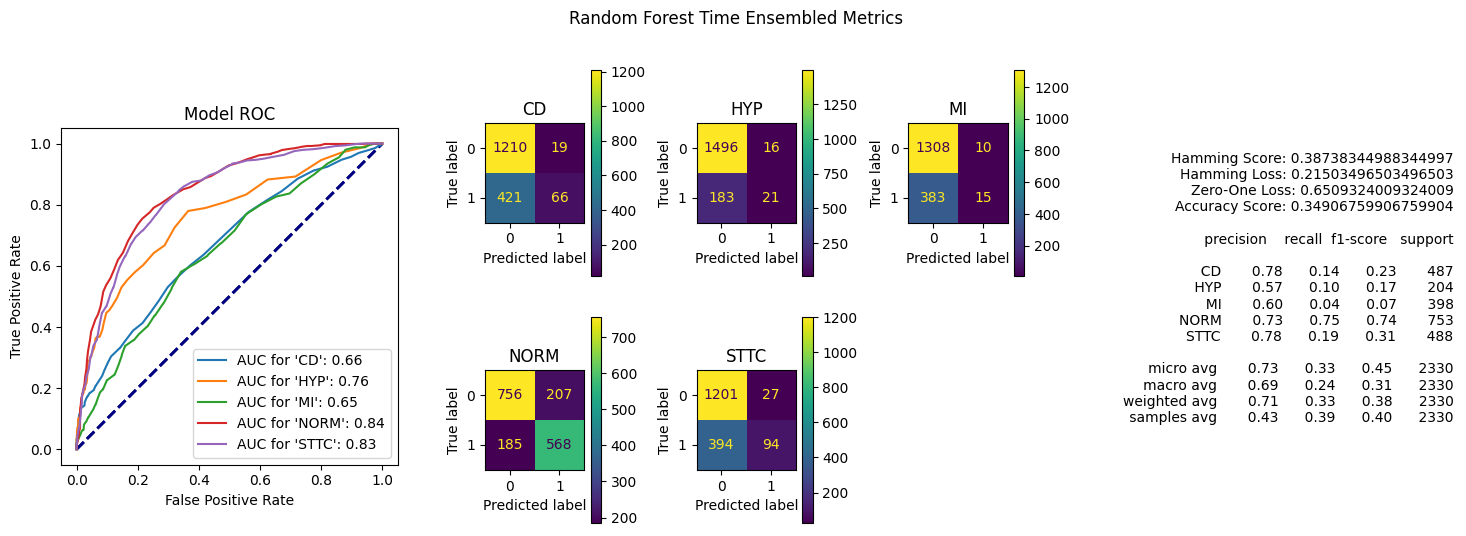

In [149]:
get_metric(model_foresten, X_te, Y_te, "Random Forest Time Ensembled").show()

Using predict_proba scoring


100%|██████████████████████████████████████████████████████████████████████████| 1716/1716 [09:12<00:00,  3.10it/s]


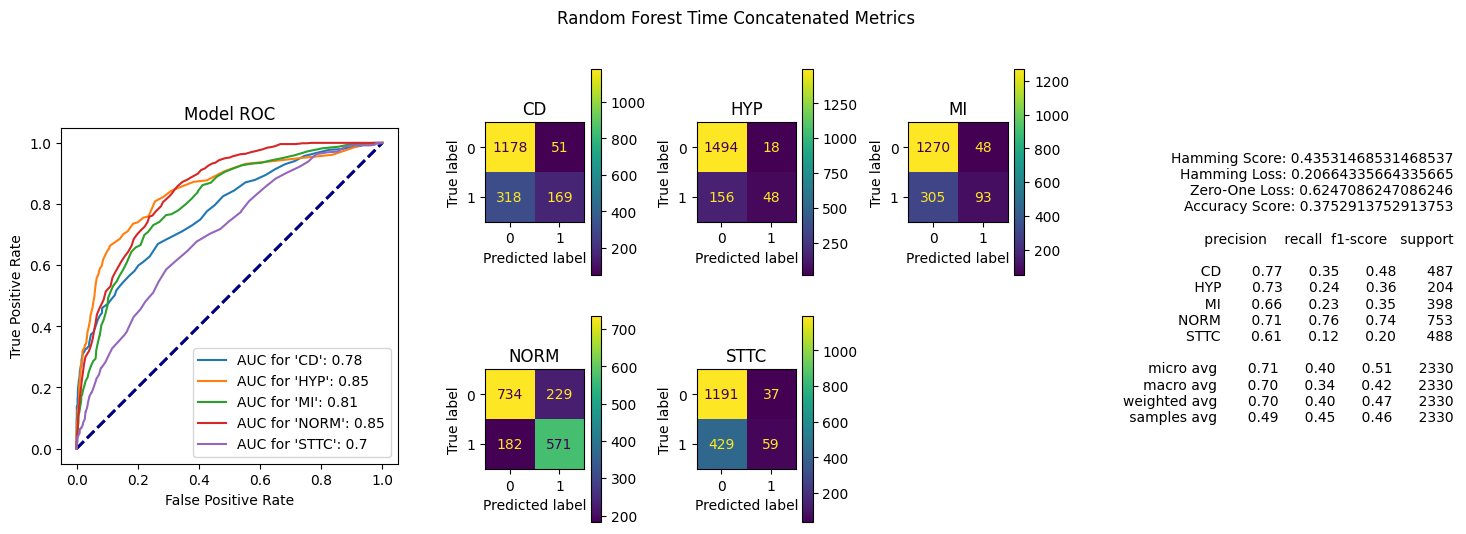

In [184]:
get_metric(model_forestcat, X_te, Y_te, "Random Forest Time Concatenated", bugfix=True).show()

Using predict_proba scoring


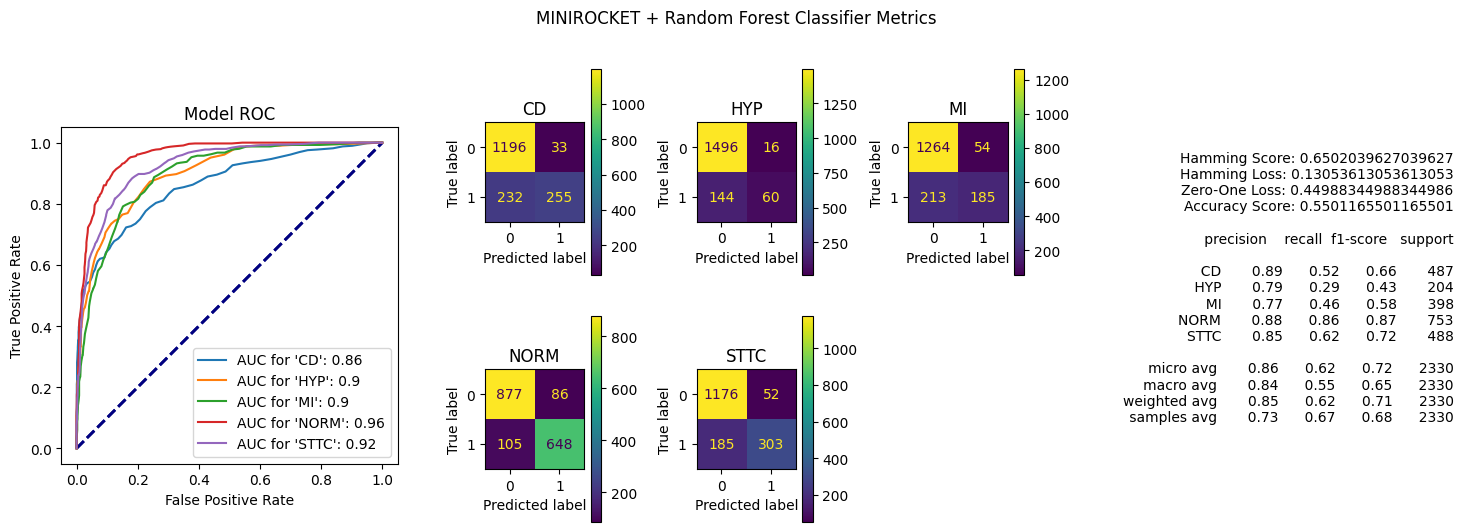

In [151]:
get_metric(model_rfc, X_te, Y_te, "MINIROCKET + Random Forest Classifier").show()

Using decision_function scoring


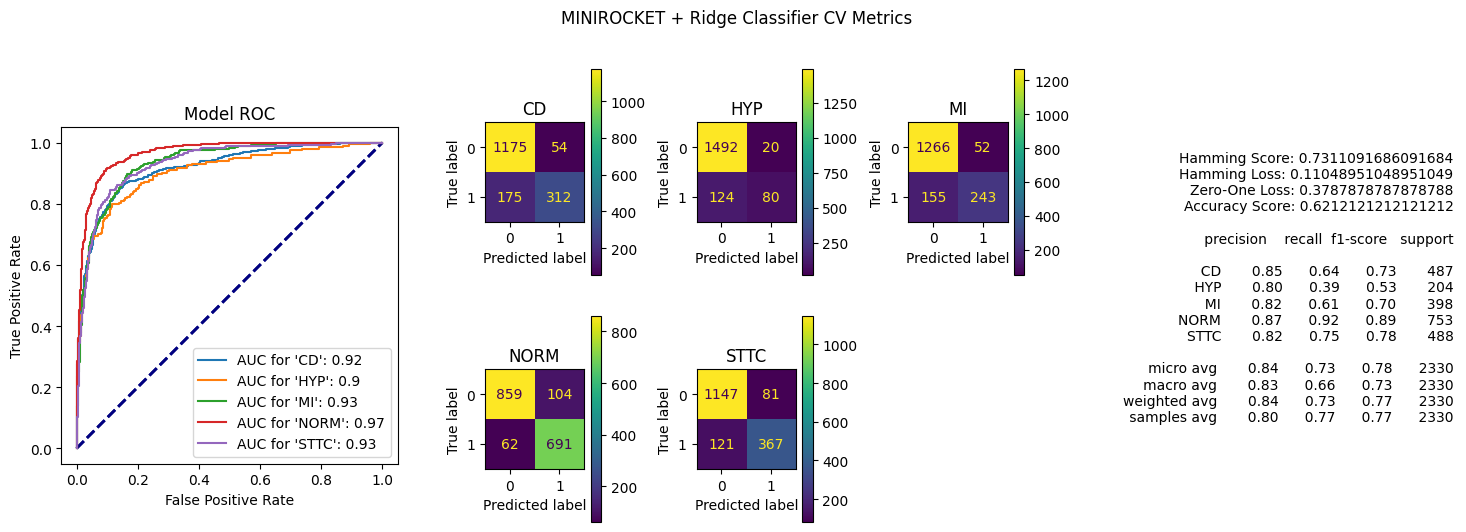

In [152]:
get_metric(model_rcc, X_te, Y_te, "MINIROCKET + Ridge Classifier CV").show()

Using fixdecfunc fix
Using decision_function scoring


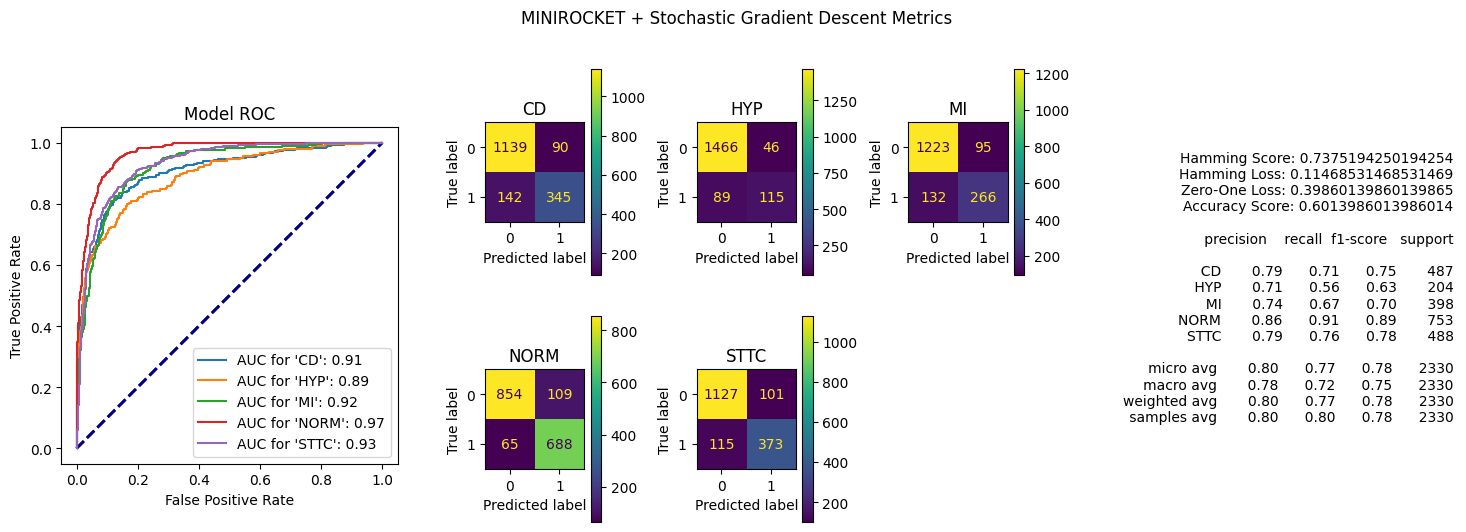

In [183]:
get_metric(model_sgd, X_te, Y_te, "MINIROCKET + Stochastic Gradient Descent", fixdecfunc=True).show()

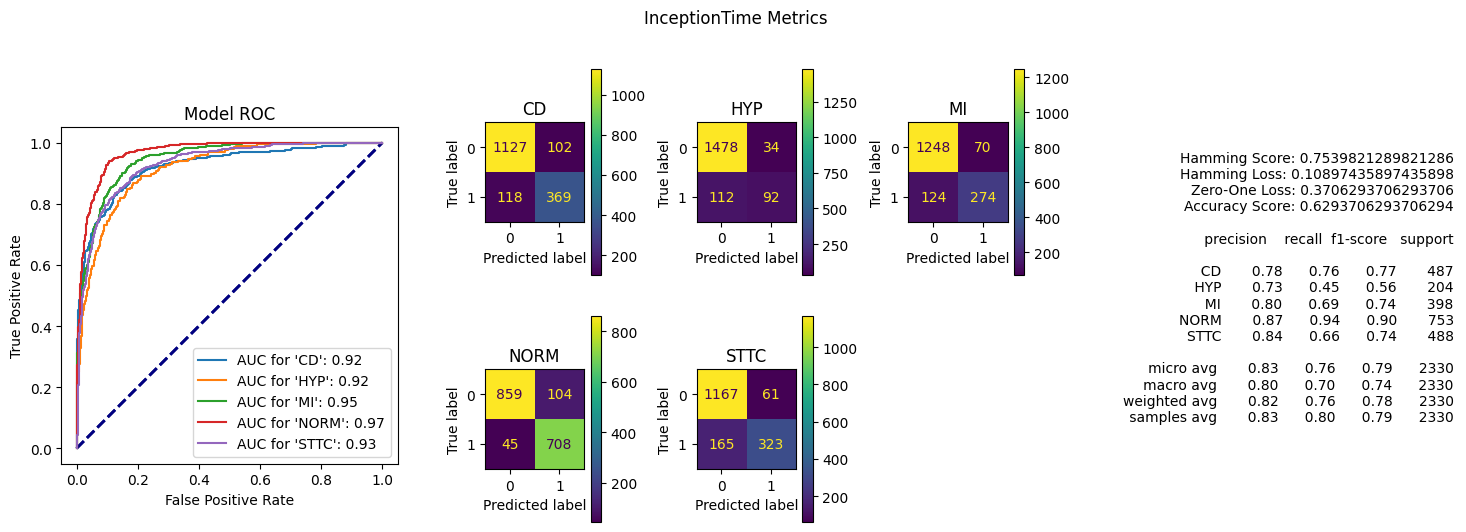

In [39]:
get_metric(model_inc, np.transpose(X_te, (0, 2, 1)), Y_te, "InceptionTime").show()

### Use MiniRocket + Stochastic Gradient Descent for our website prediction
To create the model, we can only select one out of the 12 available waveforms.
This is because our ECG sensors can only detect one waveform at a time. To
select the waveform, we have to gauge of all of the waveform model performance
individually.

In [204]:
from sktime.transformations.panel.rocket import MiniRocket
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier

# Gets the best waveform
for i in range(X_tr.shape[1]):
  classifier = MultiOutputClassifier(
    make_pipeline(
      MiniRocket(
        num_kernels=12500,
        n_jobs=-1,
      ),
      SGDClassifier(
        loss="hinge",
        alpha=0.0003,
        learning_rate="adaptive",
        eta0=0.009,
        epsilon=0.1,
        max_iter=4000,
        random_state=1314,
        penalty="elasticnet",
        n_jobs=-1,
        verbose=0
      )
    )
  )

  # Select only certain waveforms so we get univariate data
  classifier.fit(X_tr[:, i], Y_tr)
  pred = classifier.predict(X_te[:, i])
  print(f"Waveform {WAVEFORMS[i]} score:")
  print(get_metrics_str(Y_te, pred))
  print(multilabel_confusion_matrix(Y_te, pred).tolist())

Waveform I score:

Hamming Score: 0.6047202797202799
Hamming Loss: 0.17272727272727273
Zero-One Loss: 0.5174825174825175
Accuracy Score: 0.4825174825174825

              precision    recall  f1-score   support

          CD       0.73      0.51      0.60       487
         HYP       0.51      0.29      0.37       204
          MI       0.59      0.40      0.48       398
        NORM       0.78      0.87      0.82       753
        STTC       0.69      0.66      0.67       488

   micro avg       0.71      0.62      0.66      2330
   macro avg       0.66      0.54      0.59      2330
weighted avg       0.69      0.62      0.64      2330
 samples avg       0.67      0.66      0.65      2330


[[[1139, 90], [241, 246]], [[1455, 57], [145, 59]], [[1206, 112], [238, 160]], [[775, 188], [98, 655]], [[1083, 145], [168, 320]]]
Waveform II score:

Hamming Score: 0.6396173271173278
Hamming Loss: 0.16037296037296037
Zero-One Loss: 0.4836829836829837
Accuracy Score: 0.5163170163170163

          

Looking at the 12 waveform metrics from the cell above, we selected 3 of the best candidates to create the model. The chosen candidates are:
- V6
- AVR
- II

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def draw_conf(ar, title=""):
  fig, b = plt.subplots(1, 5, figsize=(22, 5))
  for i in range(5):
    ConfusionMatrixDisplay(confusion_matrix=np.array(ar[i])).plot(ax=b[i])
  fig.suptitle(title)
    
  fig.show()

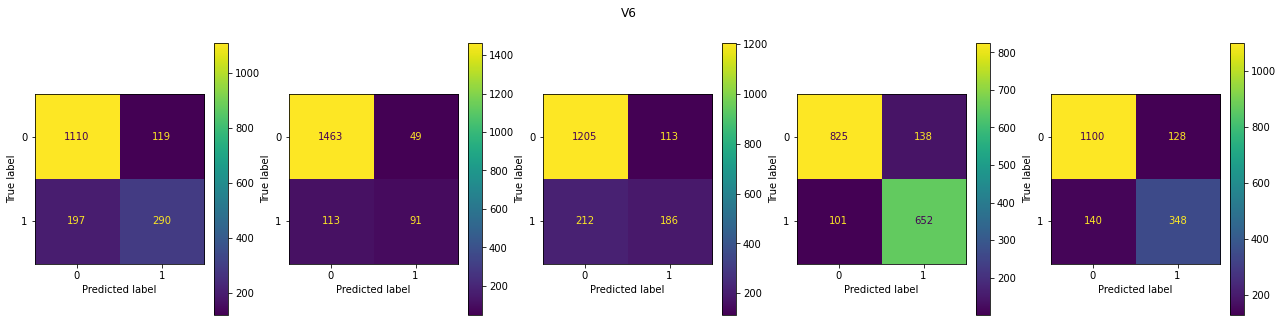

In [23]:
draw_conf([[[1110, 119], [197, 290]], [[1463, 49], [113, 91]], [[1205, 113], [212, 186]], [[825, 138], [101, 652]], [[1100, 128], [140, 348]]], "V6")

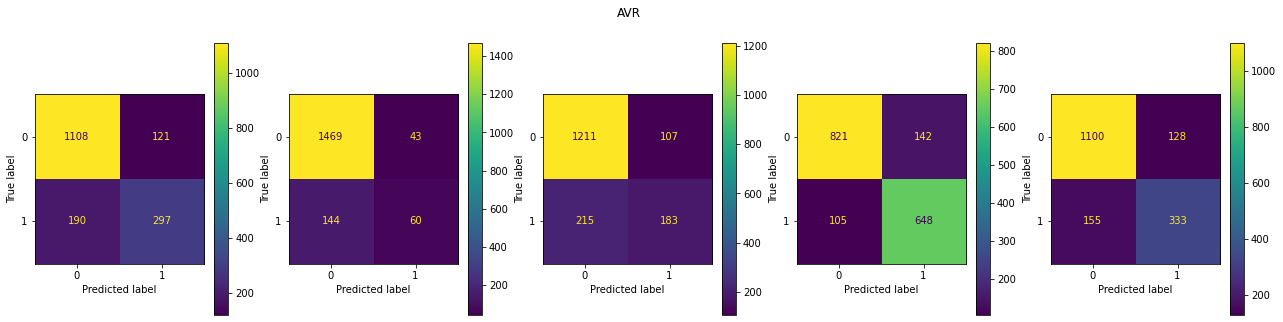

In [24]:
draw_conf([[[1108, 121], [190, 297]], [[1469, 43], [144, 60]], [[1211, 107], [215, 183]], [[821, 142], [105, 648]], [[1100, 128], [155, 333]]], "AVR")

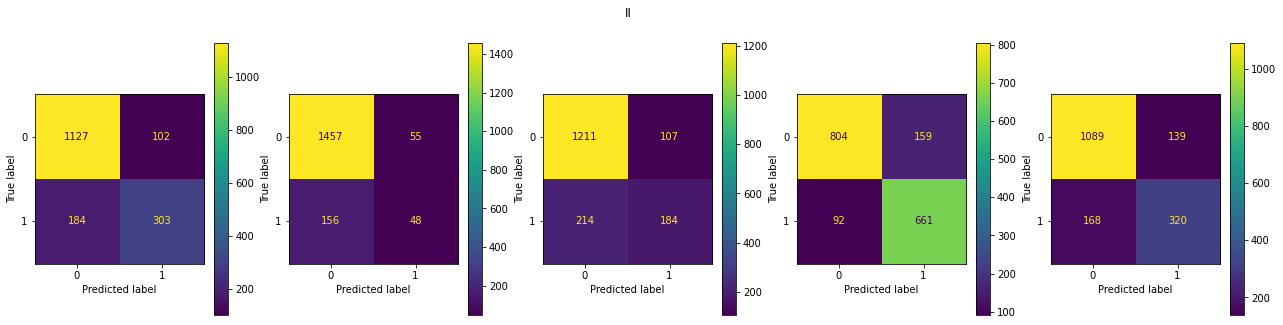

In [25]:
draw_conf([[[1127, 102], [184, 303]], [[1457, 55], [156, 48]], [[1211, 107], [214, 184]], [[804, 159], [92, 661]], [[1089, 139], [168, 320]]], "II")

### V6 Wins! Now we make a classifier for V6

In [42]:
from sktime.transformations.panel.rocket import MiniRocket
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier

model_mrsgd_v6 = MultiOutputClassifier(
  make_pipeline(
    MiniRocket(
      num_kernels=12500,
      n_jobs=-1,
    ),
    SGDClassifier(
      loss="hinge",
      alpha=0.0003,
      learning_rate="adaptive",
      eta0=0.009,
      epsilon=0.1,
      max_iter=4000,
      random_state=1314,
      penalty="elasticnet",
      n_jobs=-1,
      verbose=0
    )
  )
)

In [47]:
# Search the index of the V6 Waveform
v6_i = WAVEFORMS.index("V6")
model_mrsgd_v6.fit(X_tr[:, v6_i], Y_tr)

MultiOutputClassifier(estimator=Pipeline(steps=[('minirocket',
                                                 MiniRocket(n_jobs=-1,
                                                            num_kernels=12500)),
                                                ('sgdclassifier',
                                                 SGDClassifier(alpha=0.0003,
                                                               eta0=0.009,
                                                               learning_rate='adaptive',
                                                               max_iter=4000,
                                                               n_jobs=-1,
                                                               penalty='elasticnet',
                                                               random_state=1314))]))

In [ ]:
if SAVE_MODEL: pickle.dump(model_mrsgd_v6, open("datasetcache/_best_mrsgd_v6.pkl", "wb"), 4)

Using fixdecfunc fix
Using decision_function scoring


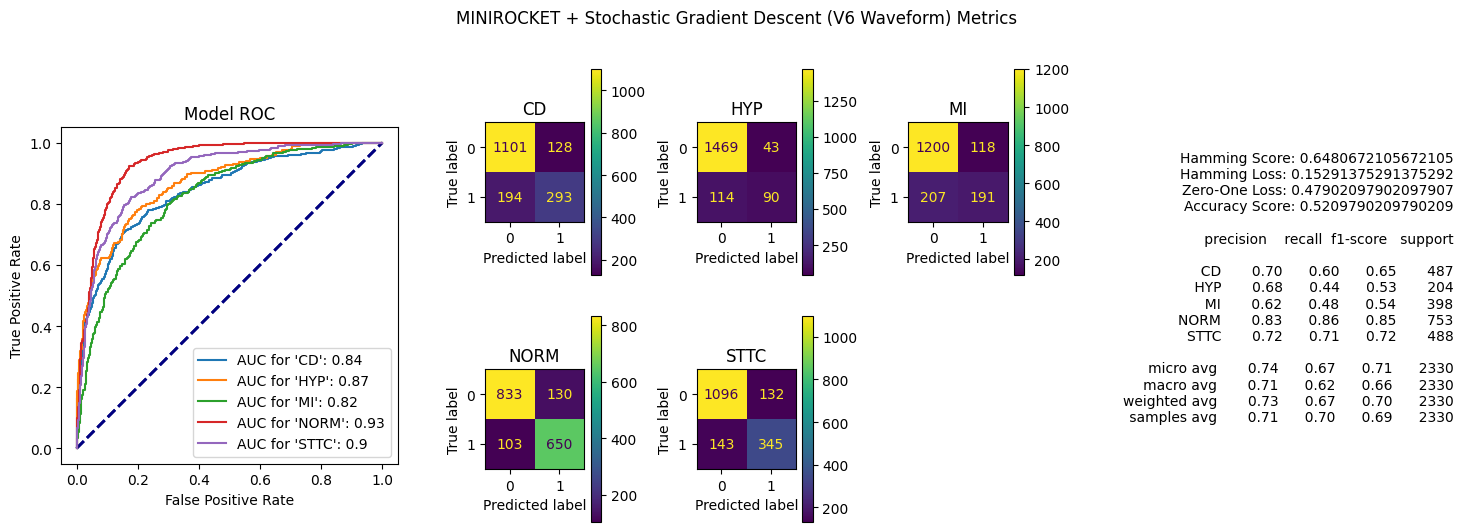

In [61]:
get_metric(model_mrsgd_v6, X_te[:, v6_i], Y_te, "MINIROCKET + Stochastic Gradient Descent (V6 Waveform)", fixdecfunc=True).show()